# MPMS rock magnetic experiments data analysis

## Import scientific python libraries

In [10]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

%matplotlib inline

## Import data

In [11]:
NED2_8c_MPMS = pd.read_csv('./MPMS_data/NED2_8c_MPMS.csv')
NED2_8c_MPMS.head()

,experiment,T [K],Bapp [T],M [Am2/kg],reg fit,timestamp
0,FC,9.994304,0,0.015529,0.984894,1/8/2020 9:39:53 PM
1,FC,15.500260,0,0.014205,0.984457,1/8/2020 9:41:15 PM
2,FC,20.576900,0,0.013058,0.984438,1/8/2020 9:42:16 PM
3,FC,25.597500,0,0.012188,0.984445,1/8/2020 9:43:18 PM
4,FC,30.620950,0,0.011418,0.984483,1/8/2020 9:44:18 PM


In [12]:
def parse_MPMS_data(MPMS):
    if 'FC' in MPMS.experiment.unique():
        MPMS_FC = MPMS[MPMS.experiment == 'FC']
    if 'ZFC' in MPMS.experiment.unique():   
        MPMS_ZFC = MPMS[MPMS.experiment == 'ZFC']
    if 'RTSIRM_cooling' in MPMS.experiment.unique():
        MPMS_RTSIRM_cool = MPMS[MPMS.experiment == 'RTSIRM_cooling']
    if 'RTSIRM_warming' in MPMS.experiment.unique():
        MPMS_RTSIRM_warm = MPMS[MPMS.experiment == 'RTSIRM_warming']
    return MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm

def plot_mpms_dc(csv_file):
    MPMS = pd.read_csv(csv_file)
    MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS)
    
    fig = plt.figure(figsize=(9,4.5))
    ax0 = fig.add_subplot(1,2,1)
    ax0.plot(MPMS_FC['T [K]'],MPMS_FC['M [Am2/kg]'],'.-',color='C1',label='FC')
    ax0.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['M [Am2/kg]'],'.-',color='C2',label='ZFC')
    ax0.set_xlim(0,300)
    ax0.set_ylabel('M (Am2/kg)')
    ax0.legend()
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['M [Am2/kg]'],'.-',color='C0',label='RTSIRM cooling')
    ax1.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['M [Am2/kg]'],'.-',color='C3',label='RTSIRM warming')
    ax1.set_xlim(0,300)
    ax1.set_ylabel('M (Am2/kg)')
    ax1.set_xlabel('T (K)')
    ax1.legend()
    
    fig.tight_layout()
    
    return fig

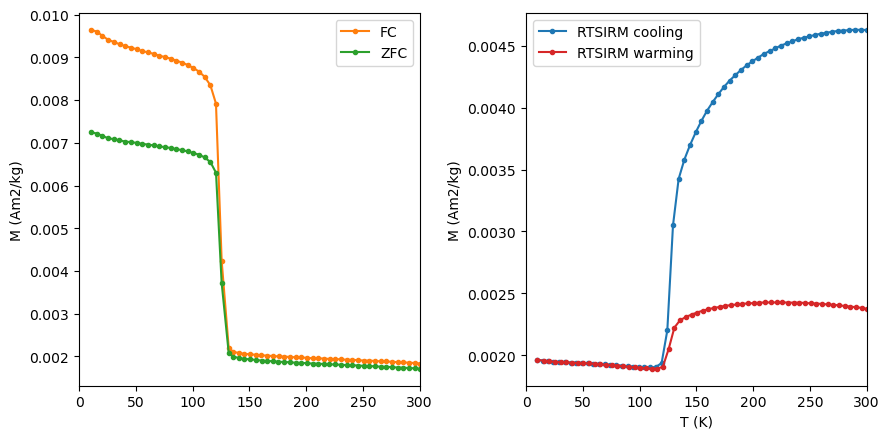

In [13]:
fig = plot_mpms_dc('./MPMS_data/NED34_6c_MPMS.csv')

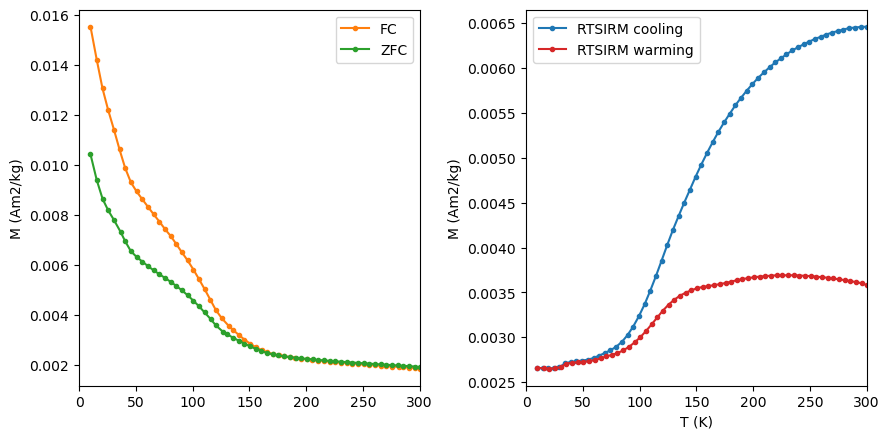

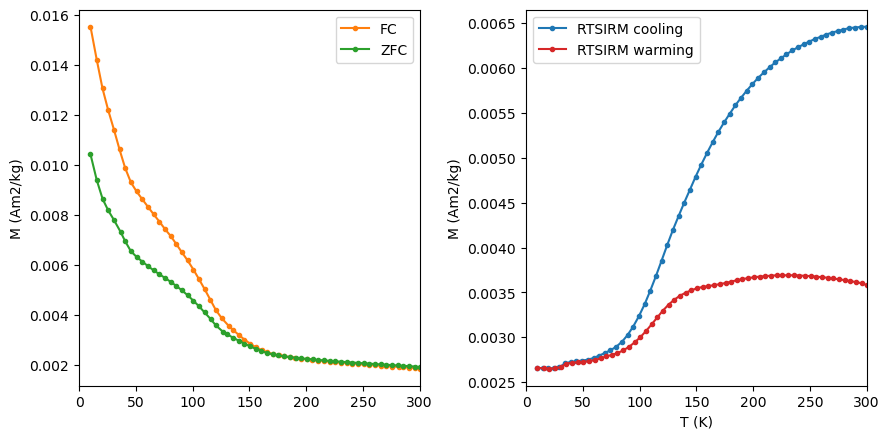

In [14]:
plot_mpms_dc('./MPMS_data/NED2_8c_MPMS.csv')

Its important to evaluate the derivative

In [15]:


def mpms_background_fit(df, t_range_background_min = 50, t_range_background_max = 250, excluded_t_min=75, excluded_t_max = 150, poly_deg = 3):
#df - > [temp,M], 
# Calculate the derivative from df
    df['dM/dT [AM2/kgK]'] = (df['M [Am2/kg]'].diff()/2)/(df['T [K]'].diff()/2)
    df_2 = df[(df['T [K]'] > t_range_background_min) & (df['T [K]'] < t_range_background_max)]
    fig = plt.figure(figsize=(9,4.5))

    poly_background_fit_green = np.polyfit(df_2['T [K]'], df_2['dM/dT [AM2/kgK]'], poly_deg)
    mgt_array = np.poly1d(poly_background_fit_green)(df_2['T [K]']) - df_2['dM/dT [AM2/kgK]']


    ax2 = fig.add_subplot(1,2,1)
    ax2.set_xlabel('T[K]')
    ax2.set_ylabel('dM/dT [AM2/kgK]')
    ax2.plot(df_2['T [K]'], np.poly1d(poly_background_fit_green)(df_2['T [K]']), color='green', label = 'bkg')
    ax2.plot(df['T [K]'],(df['dM/dT [AM2/kgK]']), color='red', label = 'total')
    ax2.plot(df_2['T [K]'],(mgt_array), color='blue', label = 'mgt')

    print(max(mgt_array.values.tolist()))
    x1_0 = df_2['T [K]'].values.tolist()
    y1_0 = mgt_array.values.tolist()
    xpos1_0 = y1_0.index(max(y1_0)) #gets the x position of the max point
    xmax_0 = x1_0[xpos1_0]
    ymax_0 = df_2['dM/dT [AM2/kgK]'].values.tolist()[xpos1_0]

    return xmax_0, ymax_0 #Returns the T [K] and dM/dT of the highest point in the red graph



In [16]:
def mpms_derivative(csv_file):
    MPMS = pd.read_csv(csv_file)
    MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS)

    #calculate the derivative of each derivative of the 
    #Calculating the derivative is by finding the difference between the values on the y-axis, and dividing it by the values on the x-axis.

    MPMS_FC['dM/dT [AM2/kgK]'] = (MPMS_FC['M [Am2/kg]'].diff()/2)/(MPMS_FC['T [K]'].diff()/2)
    MPMS_ZFC['dM/dT [AM2/kgK]'] = (MPMS_ZFC['M [Am2/kg]'].diff()/2)/(MPMS_ZFC['T [K]'].diff()/2)
    MPMS_RTSIRM_cool['dM/dT [AM2/kgK]'] = (MPMS_RTSIRM_cool['M [Am2/kg]'].diff()/2)/(MPMS_RTSIRM_cool['T [K]'].diff()/2)
    MPMS_RTSIRM_warm['dM/dT [AM2/kgK]'] = (MPMS_RTSIRM_warm['M [Am2/kg]'].diff()/2)/(MPMS_RTSIRM_warm['T [K]'].diff()/2)


    #plot the mpms_derivative of each curve
    #Take the middle points  of dy and dx to represent the data
        
    fig = plt.figure(figsize=(9,4.5))
    ax2 = fig.add_subplot(1,2,1)
    ax2.plot(MPMS_FC['T [K]'],MPMS_FC['dM/dT [AM2/kgK]'] ,'.-',color='C1',label='FC derivative')
    ax2.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['dM/dT [AM2/kgK]'],'.-',color='C2',label='ZFC derivative')
    ax2.set_xlim(0,300)
    ax2.set_xlabel('T[K]')
    ax2.set_ylabel('dM/dT [AM2/kgK]')
    ax2.legend()
    
    ax3 = plt.subplot(1,2,2)
    ax3.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['dM/dT [AM2/kgK]'],'.-',color='C0',label='RTSIRM coolin derivative')
    ax3.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['dM/dT [AM2/kgK]'],'.-',color='C3',label='RTSIRM warming derivative')
    ax3.set_xlim(0,300)
    ax3.set_ylabel('dM/dT [AM2/kgK]')
    ax3.set_xlabel('T (K)')
    ax3.legend()

    fig.tight_layout()



    #Show where the peak is for both the graphs
    xmax2_0, ymax2_0 = mpms_background_fit(MPMS_FC)
    xmax3_0, ymax3_0 = mpms_background_fit(MPMS_RTSIRM_cool)

    
    def plot_max_marker(graph, xmax, ymax):
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        graph.annotate(text, xy=(xmax, ymax), xytext=(0.,0.96), **kw)
    
    plot_max_marker(ax2,xmax2_0, ymax2_0)
    plot_max_marker(ax3,xmax3_0, ymax3_0)

    return fig
    
    

0.0006453339370055902
2.6718580070337752e-05


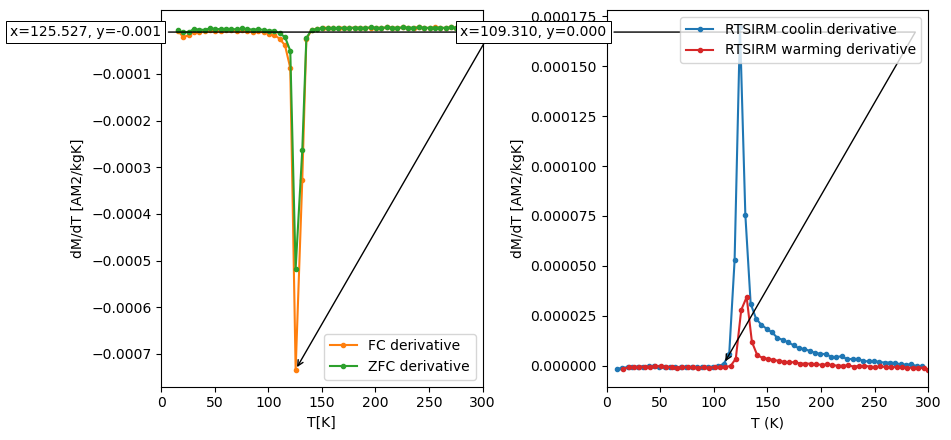

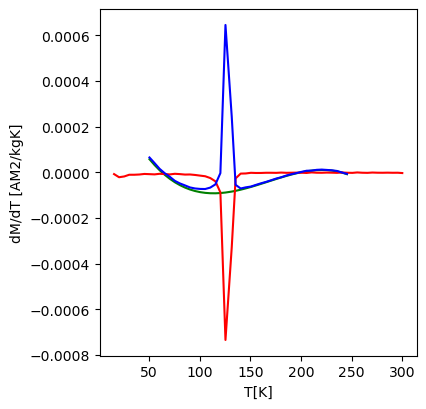

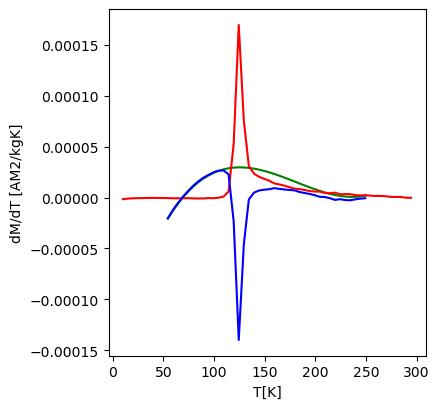

In [17]:
fig = mpms_derivative('./MPMS_data/NED34_6c_MPMS.csv')

2.5088850836448633e-05
6.304005650075606e-06


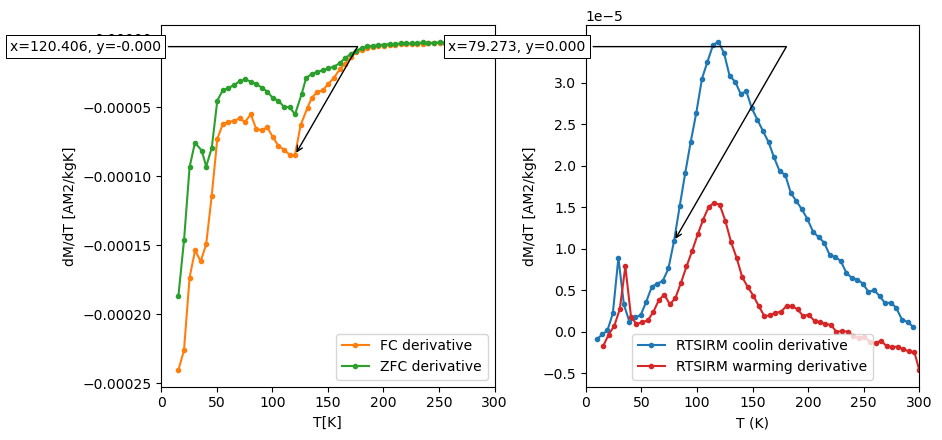

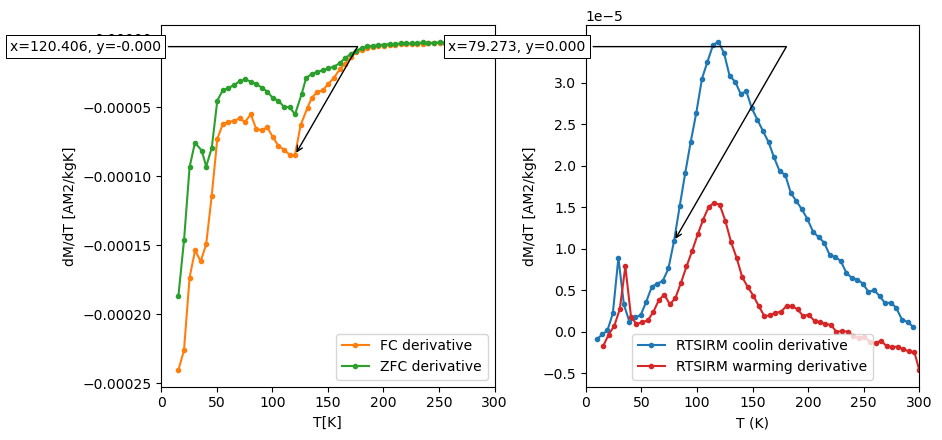

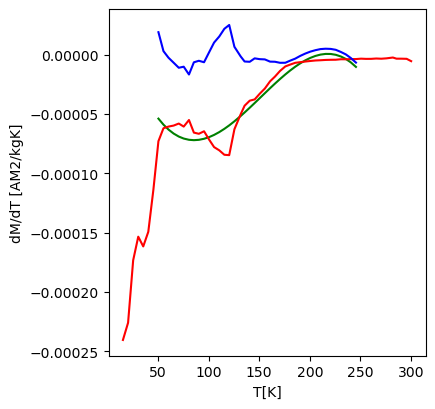

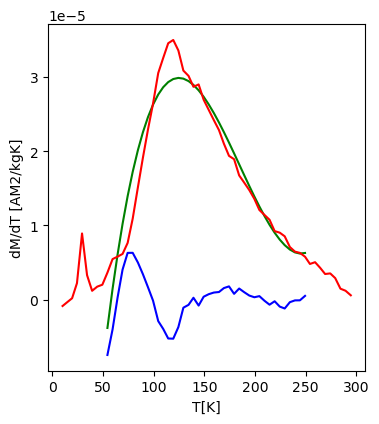

In [18]:
mpms_derivative('./MPMS_data/NED2_8c_MPMS.csv')
